### Naive Bayes classifier with Laplacian smoothing: spam-filtering

- donat un atribut discret $X^j\in\,\vec{X}$ tal que $X^j = \{x^j_1,x^j_2,\dots, x^j_l\}$ (és a dir, amb $l$ categories):

$$
\forall x^j_k\in X^{j},\,\forall c\in Y,\; P\left(X^{j} = x^{j}_k\,|\,Y=c\right) = \frac{n^{j}_{k|c} +\alpha}{\sum_{k=1}^{l}\,\left(n^{j}_{k|c} \,+\,\alpha\right)}
$$

- $\alpha$ és el paràmetre de *smoothing*, generalment considerem $\alpha = 1$

- ajuda a "generalitzar" la mostra

- assigna una probabilitat diferent de zero a les combinacions $\left(x^j_k, c\right)$ que no estan representades en la mostra (o sigui que $n^j_{k|c} = 0$)

- com més gran sigui $\alpha$ més dispersem la densitat de probabilitat ($\approxeq$ *bandwidth* en les variables contínues)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()

#### Example: Naiva Bayes classifier for spam filtering

In [2]:
df = pd.read_csv('../../data/sms/SMSSpamCollection', header=None, sep='\t', names=['Label', 'SMS'])

##### tokenize messages

In [3]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
def tokenize(message):
    for p in string.punctuation:
        message = message.replace(p, ' ')
    return message.lower().split()

In [5]:
df['tokens'] = df.SMS.apply(tokenize)

In [6]:
df.head()

,Label,SMS,tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,..."


##### train/test split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 2873)

##### build dictionary from train dataset

In [9]:
dictionary = {word: {'ham': 0, 'spam': 0} for word in list(set(X_train['tokens'].sum()))}
len(dictionary)

7884

In [10]:
def count_words(message):
    for word in message.tokens: dictionary[word][message.Label] +=1 

_ = X_train.apply(count_words, axis = 1)

##### compute likelihood functions

In [11]:
# total number of words in HAM messages
n_ham = sum([counts['ham'] for word, counts in dictionary.items()])
n_ham

57342

In [12]:
# total number of words in SPAM messages
n_spam = sum([counts['spam'] for word, counts in dictionary.items()])
n_spam

14814

In [13]:
def ham_word_likelihood(word, alpha):
    if word in dictionary:
        return (dictionary[word]['ham'] + alpha) /(n_ham +(len(dictionary) *alpha))
    else:
        return 1

In [14]:
def spam_word_likelihood(word, alpha):
    if word in dictionary:
        return (dictionary[word]['spam'] + alpha) /(n_spam +(len(dictionary) *alpha))
    else:
        return 1

#### prior

In [15]:
prior = X_train.Label.value_counts(normalize = True)
prior

ham     0.869195
spam    0.130805
Name: Label, dtype: float64

#### posterior

In [16]:
def classify(tokens, alpha):
    post_ham, post_spam = prior
    for word in tokens:
        post_ham *= ham_word_likelihood(word, alpha)
        post_spam *= spam_word_likelihood(word, alpha)
    return 'spam' if post_spam > post_ham else ('ham' if post_ham > post_spam else '??')

##### classify with smoothing parameter $\alpha$

In [69]:
alpha = 1
X_test['predicted'] = X_test.tokens.apply(lambda x: classify(x, alpha))

In [68]:
pd.concat((X_test.groupby('Label').predicted.value_counts(), X_test.groupby('Label').predicted.value_counts(normalize = True)), axis = 1)

predicted  predicted
Label predicted                      
ham   ham              950   0.998948
      ??                 1   0.001052
spam  spam             108   0.658537
      ham               56   0.341463

In [56]:
pd.concat((X_test.groupby('Label').predicted.value_counts(), X_test.groupby('Label').predicted.value_counts(normalize = True)), axis = 1)

predicted  predicted
Label predicted                      
ham   ham              949   0.997897
      ??                 2   0.002103
spam  ham              156   0.951220
      spam               8   0.048780

##### histogram

In [27]:
dict_df = pd.DataFrame([[word, counts['ham'], counts['spam']] for word, counts in dictionary.items()], columns = ['word', 'ham', 'spam'])
dict_df

,word,ham,spam
0,prakesh,1,0
1,british,0,1
2,bonus,0,13
3,top,4,12
4,soon,48,3
...,...,...,...
7879,blown,1,0
7880,shell,1,0
7881,ovr,1,0
7882,costumes,1,0


In [71]:
alpha = 100
dict_df['ham'] = dict_df['ham'] + alpha
dict_df['spam'] = dict_df['spam'] + alpha
dict_df

,word,ham,spam
0,prakesh,201,200
1,british,200,201
2,bonus,200,213
3,top,204,212
4,soon,248,203
...,...,...,...
7879,blown,201,200
7880,shell,201,200
7881,ovr,201,200
7882,costumes,201,200


<Axes: xlabel='spam', ylabel='word'>

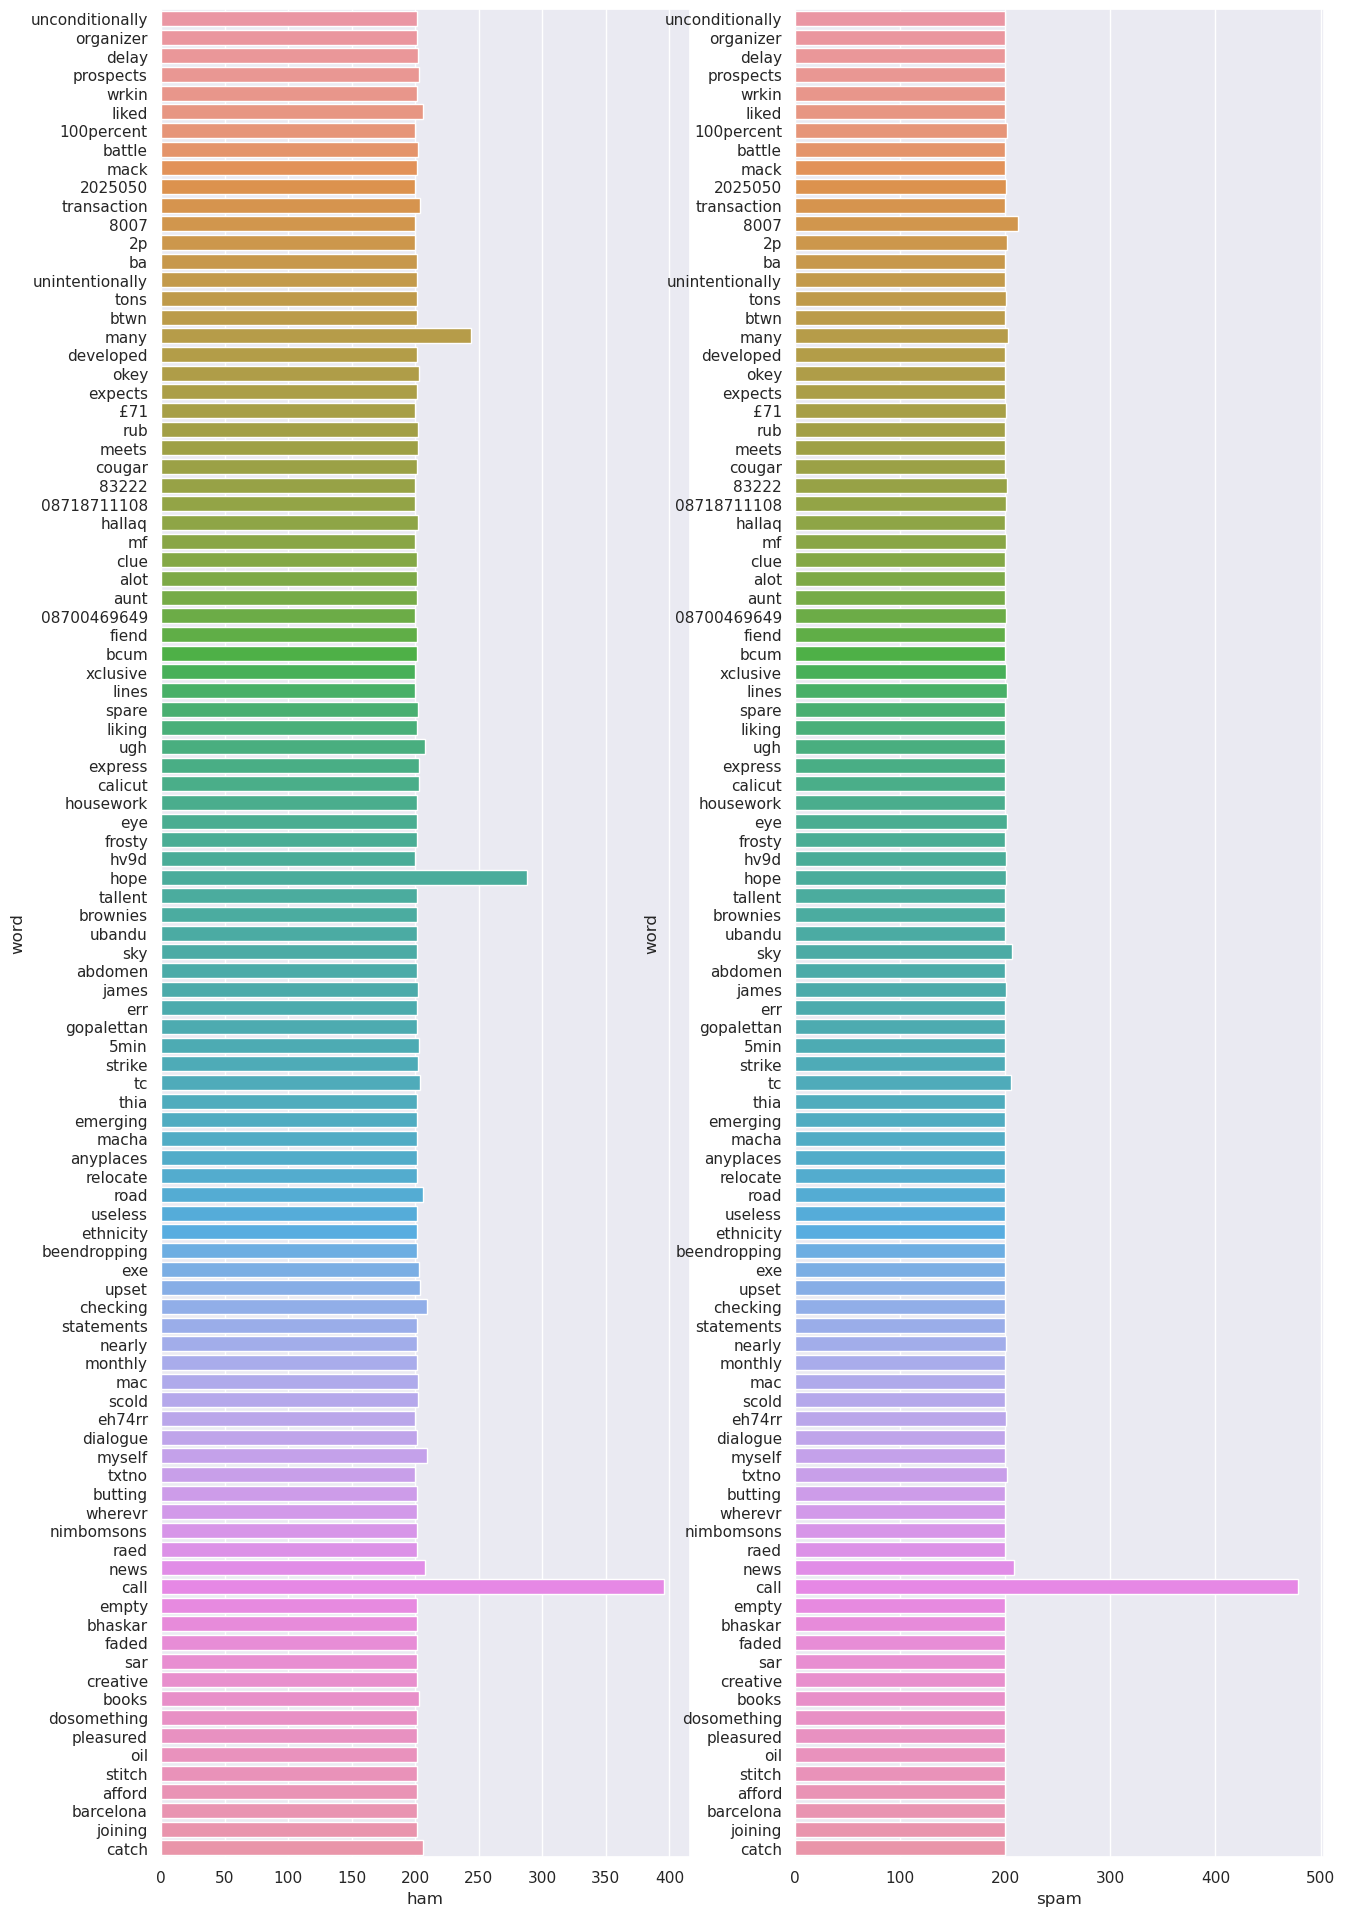

In [72]:
# take 100 random words from dictionary
idxs = np.random.randint(0, len(dictionary), 100)
df__ = dict_df.iloc[idxs].set_index('word')
df__
# bar plot
fig, axs = plt.subplots(1, 2, figsize = (15, 24))
sns.barplot(ax = axs[0], data = df__, x = 'ham', y = df__.index)
sns.barplot(ax = axs[1], data = df__, x = 'spam', y = df__.index)